In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import matplotlib.image as mpimg
import matplotlib.patches as patches

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4043,00019918_000.png,Infiltration|Pneumothorax,0,19918,052Y,F,AP,2500,2048,0.168,0.168
764,00004007_008.png,No Finding,8,4007,029Y,F,AP,2048,2500,0.168,0.168
2649,00013341_003.png,No Finding,3,13341,061Y,M,AP,2500,2048,0.168,0.168


## 1. Patient Demographic
Gender, age, view position

In [3]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
38247,00010007_166.png,Infiltration|Pleural_Thickening,166,10007,59,M,AP,2500,2048,0.168,0.168,NaN
94587,00024326_000.png,No Finding,0,24326,38,M,PA,2762,2991,0.143,0.143,NaN
27654,00007193_005.png,Mass,5,7193,47,F,PA,2048,2500,0.168,0.168,NaN


Last 20 rows = [94, 94, 94, 95, 148, 148, 149, 150, 151, 152, 153, 154, 155, 155, 411, 412, 412, 412, 413, 414]
Demographics (Age) Mean = 46.90146271851587 Std = 16.839922533381756 Mode = [58]
Demographics (Gender) = {'M': 63340, 'F': 48780}
Demographics (View Position) = {'PA': 67310, 'AP': 44810}


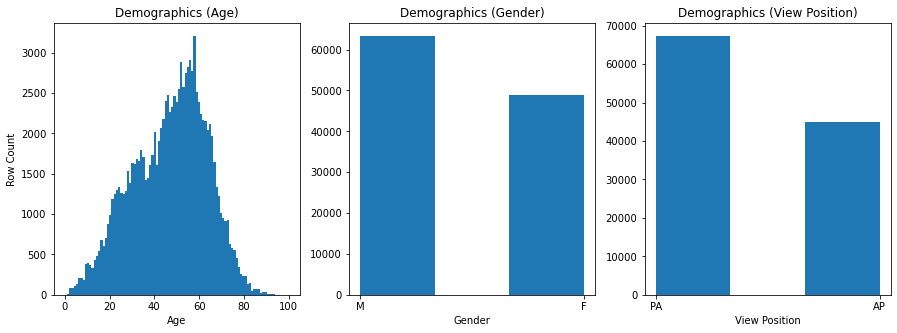

In [4]:
# all_xray_df[['Patient ID', 'Patient Age']] returns 112120 rows

# all_xray_df[['Patient ID', 'Patient Age']].drop_duplicates() returns 46115 rows
# Patient ID seem to range from 1 to 30805. However, there are more rows than Patient ID
# which is due to the Follow-up #
# Exploration show for example Patient #13, had 5 entries where the person had X ray 
# when he/she was 61, 60, 62, 56, 57. 

# The command below will ensure only 1 patient ID is taken. The df was sorted and only
# the last entry (i.e., oldest age) was taken
df_uniqueid_lastage = all_xray_df[['Patient ID', 'Patient Age']].drop_duplicates() \
    .sort_values(by=['Patient ID', 'Patient Age']) \
    .drop_duplicates(subset = ['Patient ID'], keep='last')
# pd.set_option('display.max_rows', df_uniqueid_lastage.shape[0]+1)
# df_uniqueid_lastage

# However, the demographic report give assumes each row is independent (1 data point)
# The patient demographics are as follows
df_age = all_xray_df['Patient Age'].sort_values()

# Histogram was set between 0 to 100. youngest age was 1.
print(f"Last 20 rows = {df_age.tail(20).tolist()}")
# Looking at the last 20 entries of patient age list, there were around
# 10x aged 148-155, and 6x aged 410+. Given that the older recorded
# person alive is 122 years old, I am assuming these rows have issues
# and will be disregarding them.

f, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(df_age, range=(0, 100), bins=101)
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Row Count')
ax[0].set_title('Demographics (Age)')
print(f"Demographics (Age) Mean = {df_age.mean()} Std = {df_age.std()} Mode = {df_age.mode().tolist()}")

df_gender = all_xray_df['Patient Gender']

ax[1].hist(df_gender, bins=3)
ax[1].set_xlabel('Gender')
# ax[1].set_ylabel('Row Count')
ax[1].set_title('Demographics (Gender)')
print(f"Demographics (Gender) = {df_gender.value_counts().to_dict()}")

df_view = all_xray_df['View Position']

ax[2].hist(df_view, bins=3)
ax[2].set_xlabel('View Position')
# ax[2].set_ylabel('Row Count')
ax[2].set_title('Demographics (View Position)')
print(f"Demographics (View Position) = {df_view.value_counts().to_dict()}")

## 2. Pneumonia and other Diseases

* Number of cases (pneumonia and non pneumonia)
* Comorbidity
* Number of disease per patient

In [5]:
# Split up my "Finding Labels" column so that there is one column in my dataframe per disease, 
# with a binary flag.

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
19324,00005117_000.png,Infiltration,0,5117,42,F,PA,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98953,00026167_007.png,No Finding,7,26167,18,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54808,00013712_001.png,No Finding,1,13712,18,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Has Pneumonia = {0.0: 110689, 1.0: 1431}


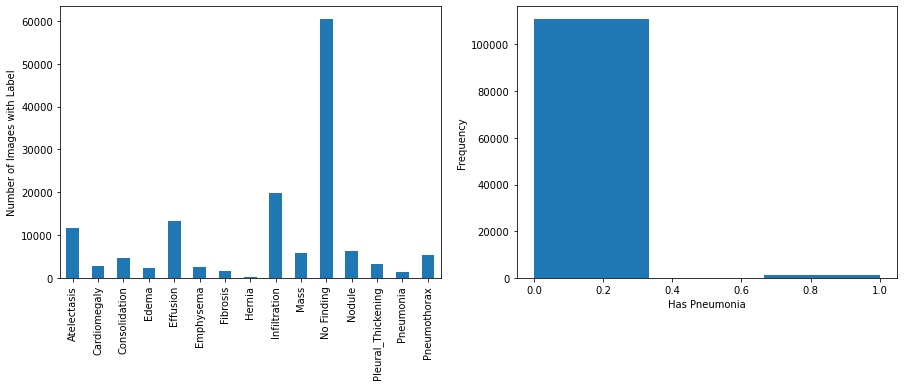

In [7]:
# Number of cases (pneumonia and non pneumonia)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

all_xray_df[all_labels].sum().plot(kind='bar', ax=ax[0])
ax[0].set(ylabel = 'Number of Images with Label')

all_xray_df['Pneumonia'].plot(kind='hist', ax=ax[1], bins=3)
ax[1].set(xlabel = 'Has Pneumonia')

print(f"Has Pneumonia = {all_xray_df['Pneumonia'].value_counts().to_dict()}")

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

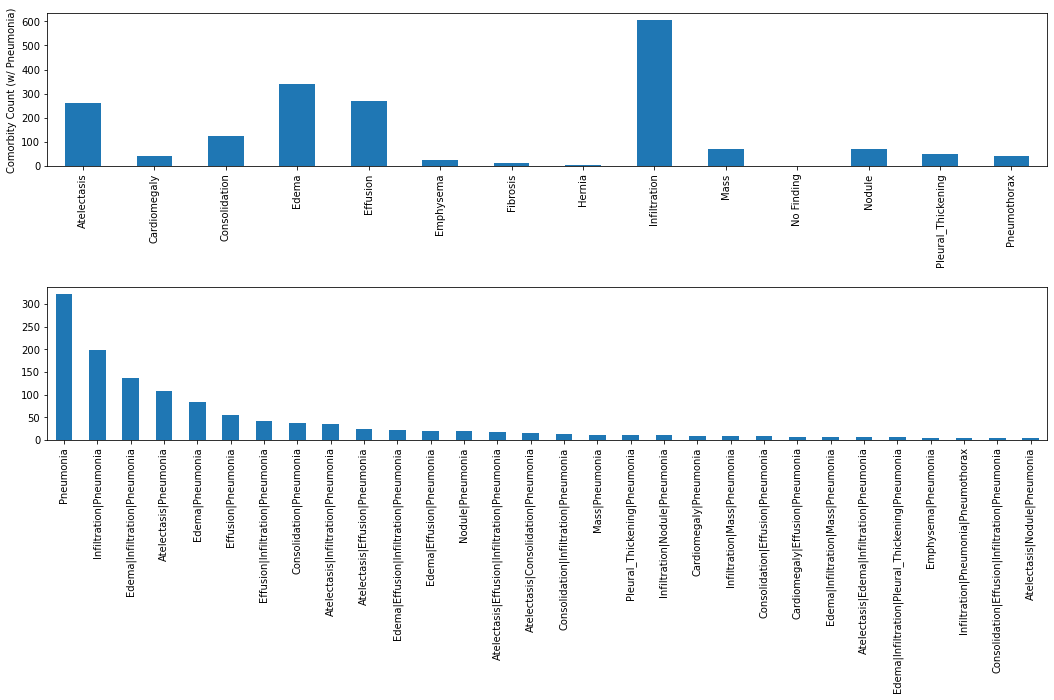

In [8]:
# Pneumonia Comorbidity
fig, ax = plt.subplots(2, 1, figsize=(15,10))

all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar', ax=ax[1])

all_labels_wout_pneumonia = all_labels.copy()
all_labels_wout_pneumonia.remove('Pneumonia')
df_pneumia = all_xray_df[all_xray_df.Pneumonia==1]
df_pneumia[all_labels_wout_pneumonia].sum().plot(kind='bar', ax=ax[0])
ax[0].set(ylabel = 'Comorbity Count (w/ Pneumonia)')

fig.tight_layout(pad=2.0)

In [9]:
# number of disease per row
all_disease_labels = all_labels.copy()
all_disease_labels.remove('No Finding')

all_xray_df['num_of_disease'] = all_xray_df[all_disease_labels].sum(axis=1)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,num_of_disease
108561,00029451_000.png,No Finding,0,29451,54,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
104983,00028166_004.png,Infiltration,4,28166,19,F,PA,1851,2021,0.194311,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26887,00007018_061.png,Edema|Infiltration|Nodule,61,7018,28,M,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0


[Text(0, 0.5, 'Patient ID Count'),
 Text(0.5, 0, 'Number of Diseases'),
 Text(0.5, 1.0, 'Number of Disease Histogram (per Patient ID)')]

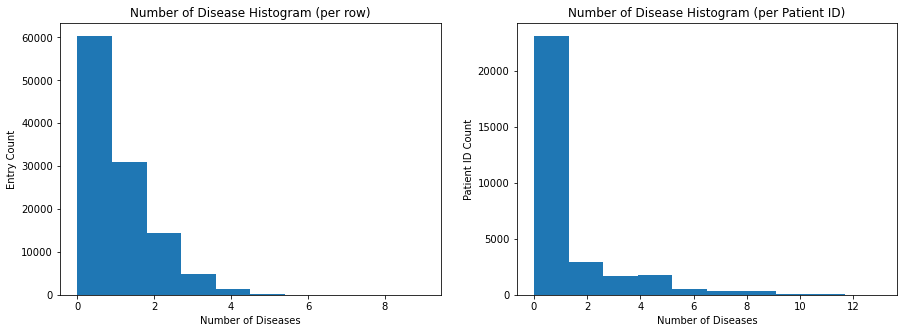

In [10]:
# Number of disease per patient
# left figure technically gives the number of disease per data row
# right figure gives the actual number of disease per patient
# if a patient has multiple entries, I 'or'-ed the diseases

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(all_xray_df['num_of_disease'])
ax[0].set(ylabel='Entry Count', xlabel='Number of Diseases', title='Number of Disease Histogram (per row)')

df_disease_per_unique_patientid = all_xray_df[['Patient ID'] + all_disease_labels] \
    .groupby('Patient ID').sum().applymap(lambda x: 1.0 if x >= 1.0 else 0.0)

df_disease_per_unique_patientid['num_of_disease'] = df_disease_per_unique_patientid[all_disease_labels].sum(axis=1)

ax[1].hist(df_disease_per_unique_patientid['num_of_disease'])
ax[1].set(ylabel='Patient ID Count', xlabel='Number of Diseases', title='Number of Disease Histogram (per Patient ID)')

Demographics (Age) Mean = 44.92732354996506 Std = 20.12986581318367 Mode = [33]
Demographics (Gender) = {'M': 838, 'F': 593}
Demographics (View Position) = {'AP': 801, 'PA': 630}


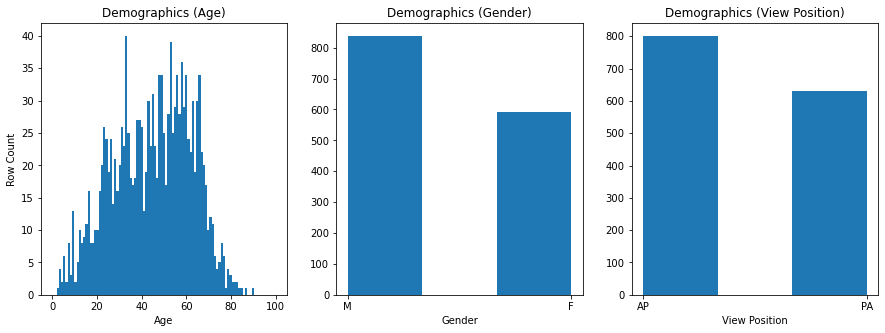

In [6]:
pneu_xray_df = all_xray_df[all_xray_df.Pneumonia==1]

df_age_pneu = pneu_xray_df['Patient Age'].sort_values()

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(df_age_pneu, range=(0, 100), bins=101)
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Row Count')
ax[0].set_title('Demographics (Age)')
print(f"Demographics (Age) Mean = {df_age_pneu.mean()} Std = {df_age_pneu.std()} Mode = {df_age_pneu.mode().tolist()}")

df_gender_pneu = pneu_xray_df['Patient Gender']

ax[1].hist(df_gender_pneu, bins=3)
ax[1].set_xlabel('Gender')
# ax[1].set_ylabel('Row Count')
ax[1].set_title('Demographics (Gender)')
print(f"Demographics (Gender) = {df_gender_pneu.value_counts().to_dict()}")

df_view_pneu = pneu_xray_df['View Position']

ax[2].hist(df_view_pneu, bins=3)
ax[2].set_xlabel('View Position')
# ax[2].set_ylabel('Row Count')
ax[2].set_title('Demographics (View Position)')
print(f"Demographics (View Position) = {df_view_pneu.value_counts().to_dict()}")

## 3. Pixel Level Assessments

for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use sample_labels.csv for the pixel-level assassements.

In [11]:
df_bbox = pd.read_csv('/data/BBox_List_2017.csv', index_col='Image Index')
subset_img = set(sample_df['Image Index'].tolist()).intersection(set(df_bbox.index.tolist()))

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

print(subset_img)
df_bbox_subset = df_bbox.loc[subset_img]
df_bbox_subset.sample(3)

{'00020065_008.png', '00021818_026.png', '00023325_019.png', '00013031_005.png', '00029940_007.png', '00012834_113.png', '00028873_004.png', '00028628_020.png', '00016786_001.png', '00020408_037.png', '00013951_001.png', '00022727_000.png', '00007444_003.png', '00030634_000.png', '00014223_009.png', '00021860_002.png', '00023089_004.png', '00027464_033.png', '00029808_003.png', '00001373_009.png', '00009256_005.png', '00015425_012.png', '00002395_007.png', '00001153_004.png', '00030434_000.png', '00011832_002.png', '00010767_008.png', '00010481_021.png', '00005140_001.png', '00021495_005.png', '00021132_000.png', '00027652_003.png', '00018419_001.png', '00019765_010.png', '00010815_006.png', '00012174_000.png', '00004342_020.png', '00011831_010.png', '00016414_000.png', '00020393_001.png', '00003789_000.png', '00011831_008.png', '00011151_004.png', '00007034_016.png', '00013249_033.png', '00008716_000.png', '00016291_002.png', '00021748_000.png', '00022883_002.png', '00015530_147.png'}

,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
Image Index,,,,,,,,
00022727_000.png,Infiltrate,206.506667,198.295712,682.666667,419.840000,NaN,NaN,NaN
00010481_021.png,Atelectasis,763.118644,551.864407,160.542373,68.338983,NaN,NaN,NaN
00013031_005.png,Effusion,19.504762,418.268783,160.372487,394.429630,NaN,NaN,NaN


In [12]:
sample_df_subset = sample_df.set_index('Image Index')
sample_df_subset = sample_df_subset.loc[subset_img]

sample_df_subset

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,,,,,,,,
00020065_008.png,No Finding,8,20065,064Y,M,PA,3056,2544,0.139000,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
00021818_026.png,Consolidation|Pneumonia,26,21818,037Y,M,PA,2992,2991,0.143000,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00023325_019.png,Atelectasis|Cardiomegaly|Effusion,19,23325,081Y,F,AP,2048,2500,0.168000,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00013031_005.png,Effusion|Pneumothorax,5,13031,054Y,M,AP,2048,2500,0.168000,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
00029940_007.png,Atelectasis|Cardiomegaly,7,29940,060Y,M,AP,3056,2544,0.139000,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00012834_113.png,Consolidation|Edema|Effusion|Pneumonia,113,12834,033Y,M,AP,2500,2048,0.168000,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00028873_004.png,Cardiomegaly,4,28873,015Y,M,PA,1549,2021,0.194311,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00028628_020.png,Mass|Nodule,20,28628,020Y,M,PA,1843,2021,0.194311,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
00016786_001.png,Infiltration|Pneumonia,1,16786,023Y,F,AP,3056,2544,0.139000,0.139000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
def plot_image(row):
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
           
    img = mpimg.imread(all_image_paths[row.name])

    ax[0].imshow(img, cmap='gray')
    ax[0].set(title='Full Image')

    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    new_img = (img.copy() - mean_intensity) / std_intensity

    ax[1].hist(new_img.ravel(), bins=256)
    ax[1].set(ylabel='Intensity', xlabel='Bins', title='Histogram (Normalised, Full Image)')

    bbox_row = df_bbox.loc[row.name]
    x, y, w, h = bbox_row['Bbox [x'], bbox_row['y'], bbox_row['w'], bbox_row['h]']

    print(f"x = {x}-{x+w}, y = {y}-{y+h}")
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

    img2 = img[int(y):int(y+h+0.5), int(x):int(x+w+0.5)]
    # ax[1][0].imshow(img2)
    mean_intensity2 = np.mean(img2)
    std_intensity2 = np.std(img2)
    new_img2 = (img2.copy() - mean_intensity2) / std_intensity2
    ax[2].hist(new_img2.ravel(), bins=256)
    ax[2].set(ylabel='Intensity', xlabel='Bins', title='Histogram (Normalised, Bounded Image)')

    fig.tight_layout(pad=1.0)

### No Findings

x = 818.631111111111-906.2399999999999, y = 316.624600694444-457.709045138888
x = 331.662222222222-707.128888888889, y = 207.397934027778-572.624600694445
x = 744.4317460317461-814.8656084656085, y = 351.08571428571406-424.7703703703702


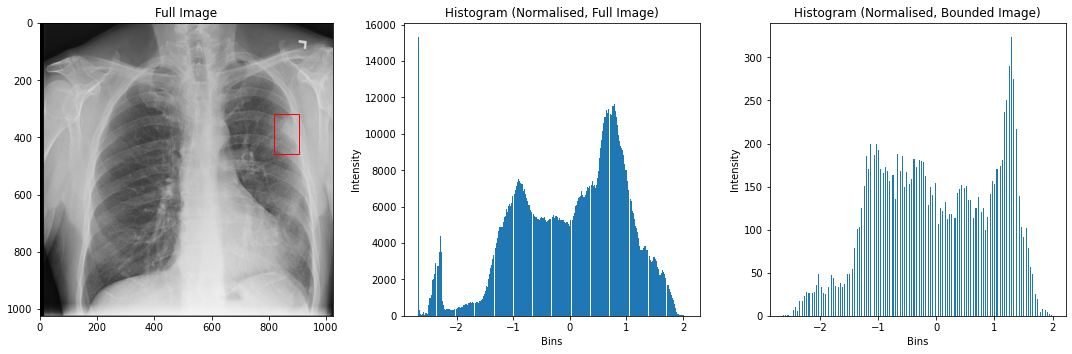

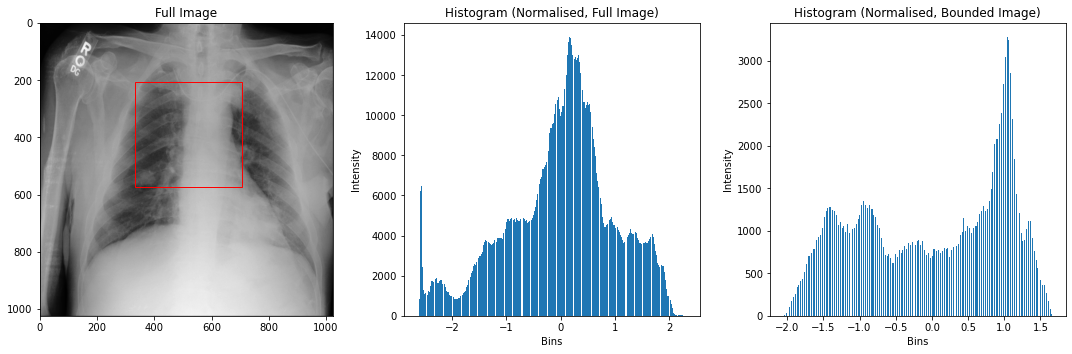

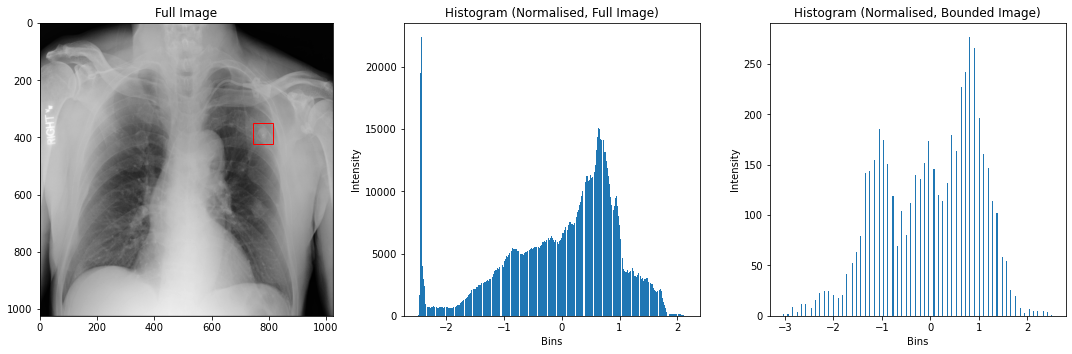

In [14]:
# No Finding
plot_image(sample_df_subset.loc['00020065_008.png'])
plot_image(sample_df_subset.loc['00011151_004.png'])
plot_image(sample_df_subset.loc['00011832_002.png'])

### Pneumonia + Other Disease

x = 272.497777777778-372.62222222222204, y = 569.211267361111-662.5090451388888
x = 564.554497354497-788.859259259259, y = 199.382010582011-690.251851851852
x = 600.313227513228-864.7111111111119, y = 297.989417989418-595.978835978836
x = 158.205291005291-327.246560846561, y = 521.210582010582-645.824338624339


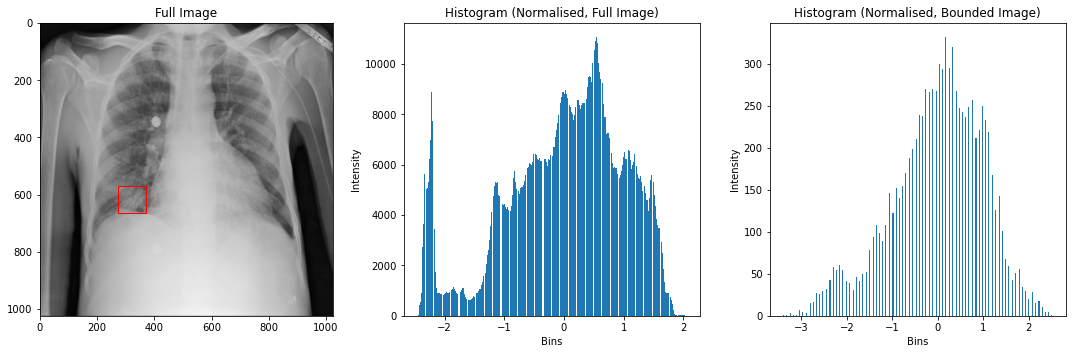

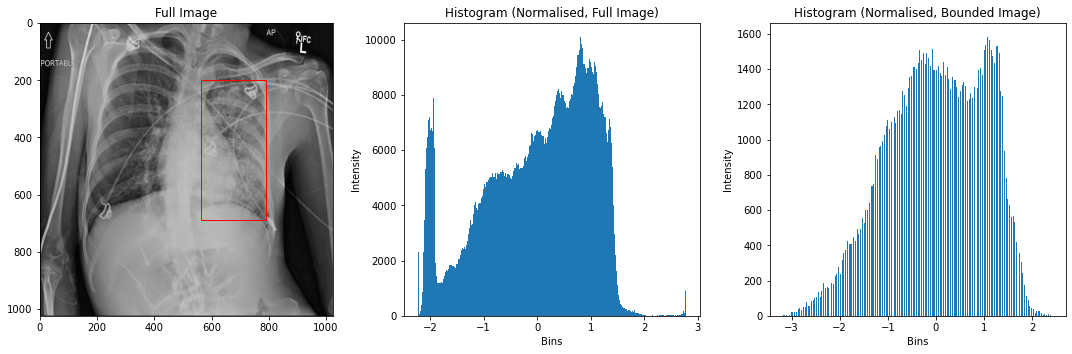

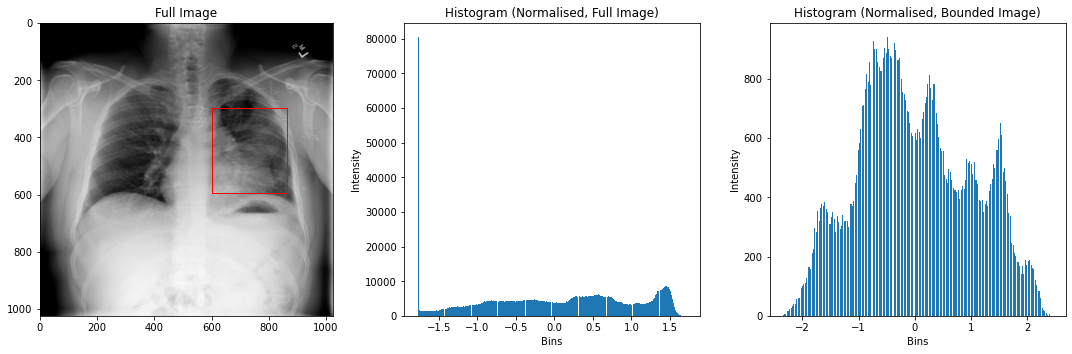

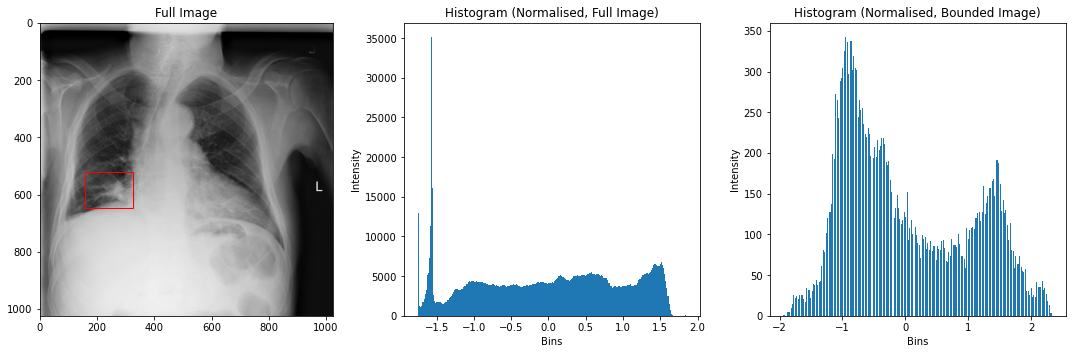

In [15]:
# Pneumonia|Nodules 00003789_000.png
plot_image(sample_df_subset.loc['00003789_000.png'])
# Infiltration|Pneumonia 00016786_001.png
plot_image(sample_df_subset.loc['00016786_001.png'])
# Consolidation|Pneumonia 00021818_026.png
plot_image(sample_df_subset.loc['00021818_026.png'])
# Infiltration|Pneumonia 00023089_004.png
plot_image(sample_df_subset.loc['00023089_004.png'])

### Average Distribute across diseases

Text(0.5, 0.98, 'Per Disease Histogram (taken 100 samples randomly)')

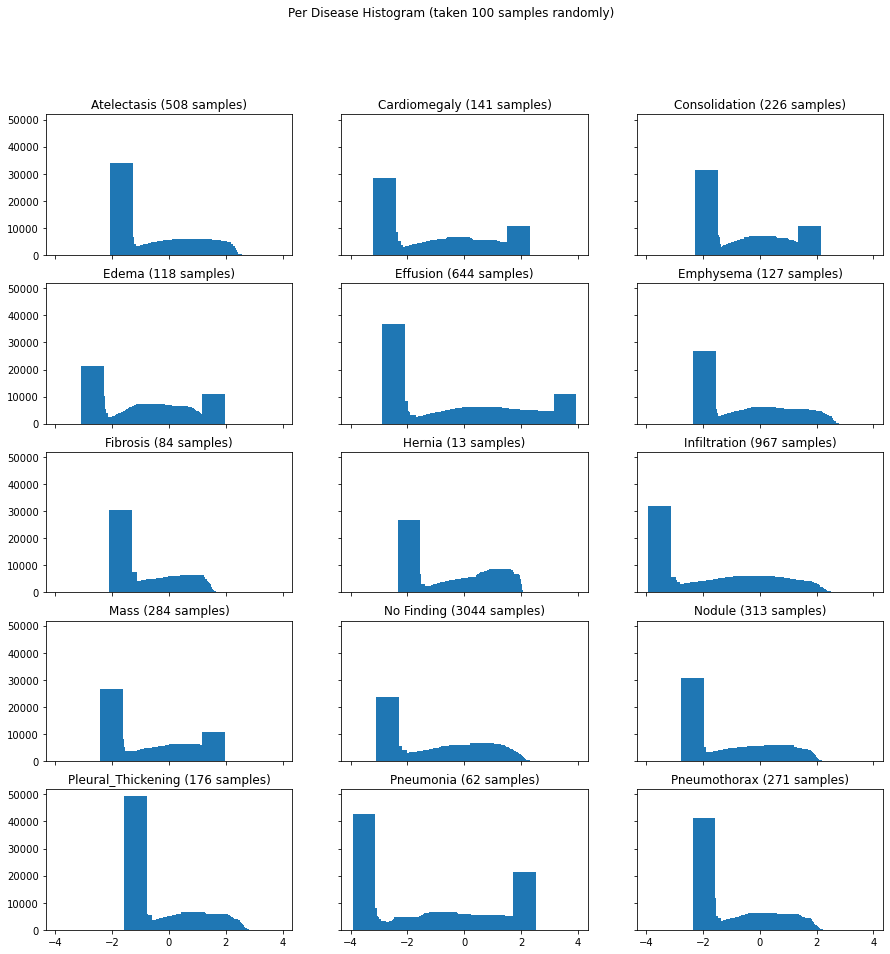

In [16]:
# Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.
# Note: use full NIH data to perform the first a few EDA items and use sample_labels.csv for the pixel-level assassements.
fig, ax = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(15,15))
num_of_samples_taken = 100
bin_size = 256

for label_idx, label in enumerate(all_labels):
    sample_df_buf = sample_df[sample_df[label] == 1.0]
    
    # print(f"{label} ({sample_df_buf.shape[0]})")

    h_buf = np.zeros(bin_size)
    
    row_count = 0
    for idx, row in sample_df_buf.sample(num_of_samples_taken, replace=True).iterrows():
        img = mpimg.imread(all_image_paths[row['Image Index']])
        
        mean_intensity = np.mean(img)
        std_intensity = np.std(img)
        
        img2 = (img.copy() - mean_intensity) / std_intensity
        
        h, bin_edges = np.histogram(img2.ravel(), bins=bin_size)
        h_buf += h
        
        row_count += 1
            
    # h_buf /= sample_df_buf.shape[0]
    h_buf /= row_count
    
    ax[int(label_idx/3)][label_idx%3].bar(bin_edges[:-1], h_buf)
    ax[int(label_idx/3)][label_idx%3].set(title=f"{label} ({sample_df_buf.shape[0]} samples)")
    
fig.suptitle(f'Per Disease Histogram (taken {num_of_samples_taken} samples randomly)')

### Also, describe your findings and how will you set up the model training based on the findings.
Figure above shows the average pixel distribution for each disease. 

* The spikes in the pixel distributions vary slightly per disease. All of them have a spike on the left side, while some of have a spike on the right side as well. The spike on the left side typically comes from the black part of the the Xray scan, hence making conclusion from it is difficult. The spike on the right side however, can mean something (eg, the mass in Xray appears white which causes a spike on the right side).
* The minimum, maximum, range (max minus min), average, also changes per disease. Notable, Pneumonia has a range of 6, min of -4.
* The model shall most likely learn patterns around pixel distribution, at the same time learning to localise of important locations of the image.
* The pixel distribution shape and metrics (eg, min, max, ave) seem to differ quite well between Pneumonia and No Findings. This indicates that a classification between the two is possible. However, there is severe imbalance of samples between the two, hence sampling to ensure the training and test data are on the right proportion shall be needed.
* Atelectasis, Edema, Effusion, and Infiltration are common comorbidities of Pneumonia (~300 or ~600 out of 1431). In addition to validating the model for classifying between Pneumonia and No Findings, extra validation must be given for scans with comorbidities (i.e., Pneumonia and another disease), have disease but w/out Pneumonia, and No Findings. The model have learned features from comorbidities instead of Pneumonia. Proper definition of device limination may be required.